In [1]:
import numpy as np
import numba as nb
import matplotlib.pyplot as plt
import timeit

# 2
Реализуйте произведение матриц $A\in Mat(N\times K)$, $B\in Mat(K\times M)$ согласно определению
$$
C_{n,m}=\sum_{k=1}^K A_{n,k}B_{k,m}.
$$
Сравните быстродействие реализаций на основе numpy.sum, с помощью numba и стандартный метод numpy.dot.
Насколько полно используется процессор? Сколько используется памяти?

In [3]:
# -m -- флаг, показывающий обращение к памяти
@nb.njit('float64[:,:](float64[:,:],float64[:,:])', nopython=True)
def matsum(A, B):
    N, K = A.shape # O(1) -m
    M = B.shape[1] # O(1) -m
    C = np.empty((N,M), dtype = nb.float64) # O(NM) -m
    for n in range(N): 
        """
        O(N)
        """
        for m in range(M):
            """
            O(M)
            """
            s = 0  # O(1) -m
            for k in range(K):
                """ 
                O(K)
                """
                s += A[n,k]*B[k,m] 
                """
                O(1) -- умножение n*k и m*k для обращения к памяти 
                O(1) -m -- полученеи A[n,k] и B[k,m] 
                O(1) -- умножение
                O(1) -- сложение
                """
            C[n,m] = s  # O(1) -m
    return C

C:\Users\droid\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numba\core\decorators.py:253: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


In [4]:
N_max = 100  # не общий разер матриц
K_max = 100000  # общай размер матриц
A = np.random.random((N_max, K_max))
B = np.random.random((K_max, N_max))

In [4]:
gen = range(5000, 9001, 200)

def time_sum(n):
    return timeit.timeit(stmt = "matsum(A[:, :%(n)s], B[:%(n)s, :])" % {'n': n},
                         globals = {'matsum': matsum, 'A': A, 'B': B}, number = 100)



In [5]:
time2 = list(time_sum(n) for n in gen)
ks = list(gen)

In [6]:
time_dot = np.array([timeit.timeit(stmt = "A[:, :%(n)s].dot(B[:%(n)s, :])" % {'n': n},
                    globals = {'A': A, 'B': B}, number = 100) for n in gen])

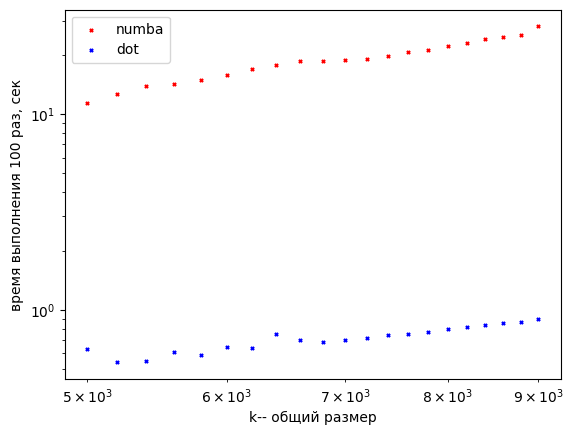

In [7]:
plt.scatter(ks, time2, marker='x', s=5, c='r', label='numba')
plt.scatter(ks, time_dot, marker='x', s=5, c='b', label='dot')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('k-- общий размер')
plt.ylabel('время выполнения %s раз, сек'%100)
plt.legend()

# 3 

Составьте модель использования вычислительных ресурсов функцией на основе numba.jit из предыдущего пункта. Размеры матриц должны быть параметрами модели. Проведите вычислительные эксперименты, чтобы подобрать параметры модели. Экстраполируйте результат на большие матрицы, сделайте экспериментальную проверку.

$$
T(K(NM))= a\cdot(KNM) + b\cdot(KN) + c\cdot(KM) + d\cdot(MN) + e\cdot(K) + f\cdot(M) + g\cdot(N) + h
$$

Это общая модель, но мы изменяем только размер K, так что в таком случае этот алгоритм будет линейный (по K)

Попытаемся понять, за что будут отвечать кажый коэффициент:

   1. $h$ -- операции, не зависящие от размеров массивов

    N, K = A.shape # O(1) -m
    M = B.shape[1] # O(1) -m
   
   2. $g, f, e = 0$ отдельно по ним ничего не выполняется 
   3. $d$ -- объявление суммы s и записть в C[n,m]

    s = 0  # O(1) -m
   
    C[n,m] = s  # O(1) -m
   
   4. $c, b=0$
   5. $a$ -- тело цикла по K

    s += A[n,k]*B[k,m]  # O(1)
   

Таким образо получаем, дополняя выражения по отношению к памяти:

$$
T(K(NM))= (a_{arithmetic}+a_{memory})\cdot(KNM) + b_{memory}\cdot(MN) + h_{memory}
$$

In [6]:
N_max = 1000  # не общий разер матриц
K_max = 100000  # общай размер матриц
A = np.random.random((N_max, K_max))
B = np.random.random((K_max, N_max))

In [7]:
@nb.njit('(float64[:,:],float64[:,:])', nopython=True)
def h(A, B):
    """
    функция для определения h 
    """
    N, K = A.shape # O(1) -m
    M = B.shape[1] # O(1) -m
    C = np.empty((N,M), dtype = nb.float64) # O(NM) -m
    return C
    

C:\Users\droid\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numba\core\decorators.py:253: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


h=3e-06 sec.


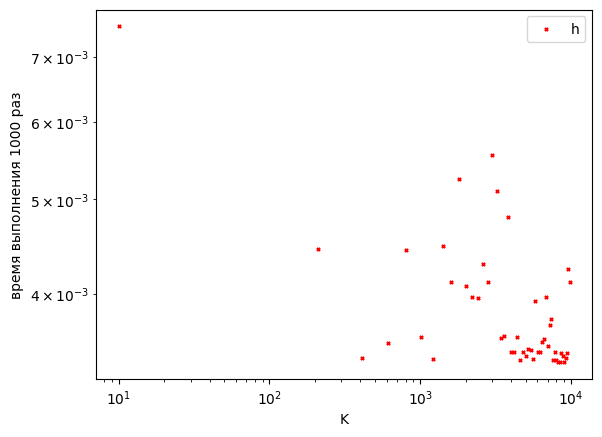

In [8]:
hgen = range(10, 10000, 200)

def htime(k, nm, number):
    return timeit.timeit(stmt = "h(A[:%(nm)s, :%(k)s], B[:%(k)s, :%(nm)s])" % {'k': k, 'nm': nm},
                         globals = {'h': h, 'A': A, 'B': B}, number = number)

h_list = list(htime(k, 100, 1000) for k in hgen)
hks = list(hgen)
h = min(h_list)/1000
plt.scatter(hks, h_list, marker='x', s=5, c='r', label='h')
plt.yscale('log')
plt.xscale('log')
plt.ylabel('время выполнения 1000 раз')
plt.xlabel('K')
plt.legend()
print('h=%.0e sec.'%h)

In [7]:
gen3k = range(5000, 7001, 200)

def time_sum_3(k, nm):
    return timeit.timeit(stmt = "matsum(A[:%(nm)s, :%(k)s], B[:%(k)s, :%(nm)s])" % {'k': k, 'nm': nm},
                         globals = {'matsum': matsum, 'A': A, 'B': B}, number = 100)


time3k = list(time_sum_3(k, 100) for k in gen3k)
ks3k = list(gen3k)

In [12]:
def time_sum_3_noslace(k, nm):
    return timeit.timeit(stmt="matsum(a, b)", globals={"matsum": matsum, "a": A[:nm, :k], "b": B[:k, :nm]}, 
                         number=100)

In [73]:
g = range(1000, 2000, 100)

s = list(time_sum_3(k, 100) for k in g)
n = list(time_sum_3_noslace(k, 100) for k in g)

sks = list(g)

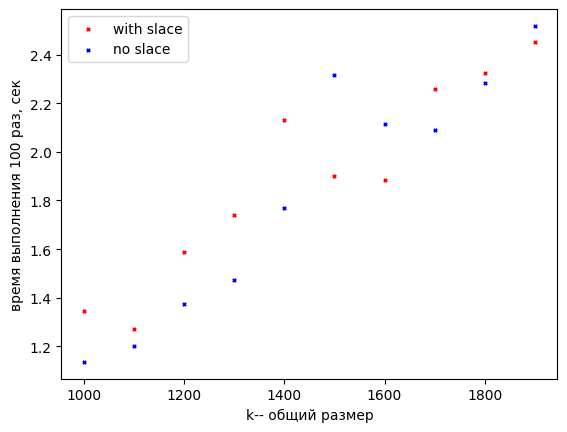

In [74]:
plt.scatter(sks, s, marker='x', s=5, c='r', label='with slace')
plt.scatter(sks, n, marker='x', s=5, c='b', label='no slace')
#plt.yscale('log')
#plt.xscale('log')
plt.xlabel('k-- общий размер')
plt.ylabel('время выполнения %s раз, сек'%100)
plt.legend()

In [13]:
time3k_noslace = list(time_sum_3_noslace(k, 100) for k in gen3k)

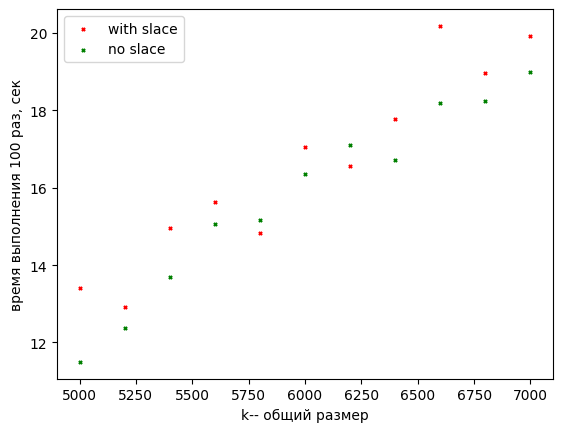

In [14]:
plt.scatter(ks3k, time3k, marker='x', s=5, c='r', label='with slace')
plt.scatter(ks3k, time3k_noslace, marker='x', s=5, c='g', label='no slace')
#plt.yscale('log')
#plt.xscale('log')
plt.xlabel('k-- общий размер')
plt.ylabel('время выполнения %s раз, сек'%100)
plt.legend()

# Вопрос к нелинейности функции 

## Ответ 

Получилось так, что мы включаем таймер до того, как делаем слайс, так что он тоже считался.

In [76]:
g11 = range(100, 200)

s11 = list(time_sum_3(k, 100) for k in g11)
n11 = list(time_sum_3_noslace(k, 100) for k in g11)
k11 = list(g11)

In [24]:
g12 = range(1000, 3001, 200)

s12 = list(time_sum_3(k, 100) for k in g12)
n12 = list(time_sum_3_noslace(k, 100) for k in g12)
k12 = list(g12)

In [25]:
g21 = range(5000, 7001, 250)

s21 = list(time_sum_3(k, 100) for k in g21)
n21 = list(time_sum_3_noslace(k, 100) for k in g21)
k21 = list(g21)

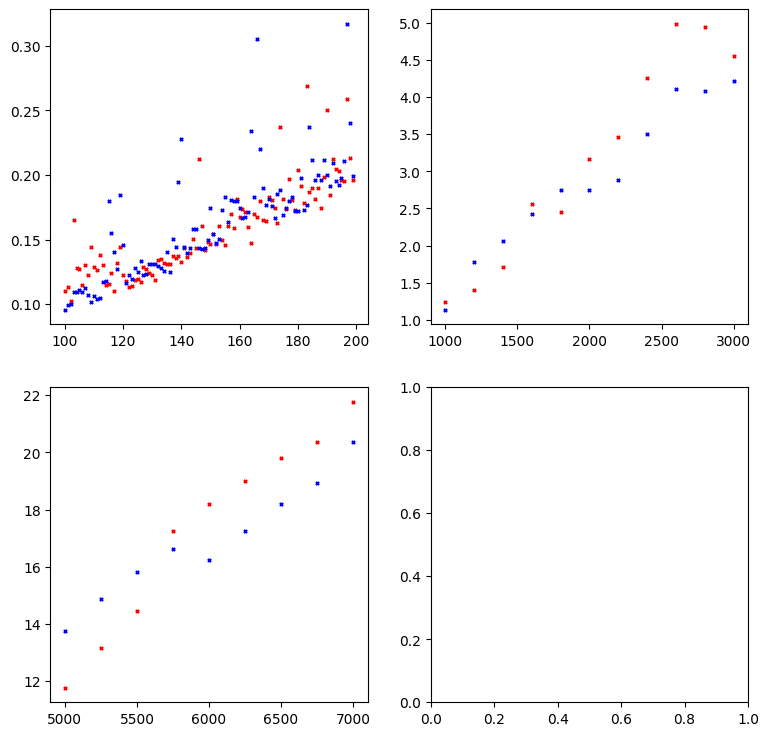

In [77]:
fig, axs = plt.subplots(2, 2, figsize=(9, 9))

axs[0, 0].scatter(k11, s11, marker='x', s=5, c='r', label='with slice')
axs[0, 0].scatter(k11, n11, marker='x', s=5, c='b', label='no slice')
# axs[0, 0].set_yscale("log")
# axs[0, 0].set_xscale("log")

axs[0, 1].scatter(k12, s12, marker='x', s=5, c='r', label='with slice')
axs[0, 1].scatter(k12, n12, marker='x', s=5, c='b', label='no slice')
# axs[0, 1].set_yscale("log")
# axs[0, 1].set_xscale("log")

axs[1, 0].scatter(k21, s21, marker='x', s=5, c='r', label='with slice')
axs[1, 0].scatter(k21, n21, marker='x', s=5, c='b', label='no slice')
# axs[1, 0].set_yscale("log")
# axs[1, 0].set_xscale("log")

In [41]:
ncoef3k = np.polyfit(slk,stime, 1)
nline3k = np.poly1d(ncoef3k)

print('NO SLICE: a*100*100=%.2e, (b*100*100 + h)=%.2e'%tuple(ncoef3k))

NO SLICE: a*100*100=1.00e-03, (b*100*100 + h)=2.83e-01


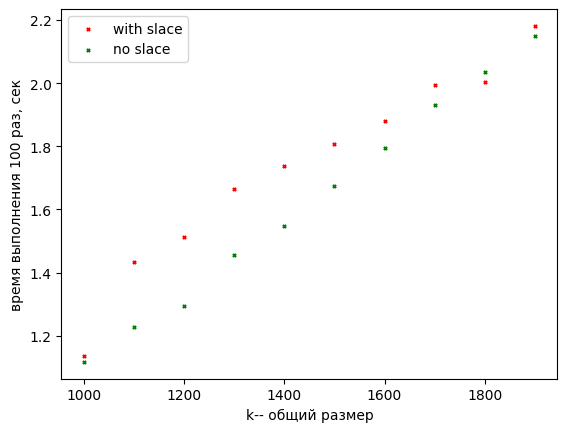

In [22]:
plt.scatter(slk, stime, marker='x', s=5, c='r', label='with slace')
plt.scatter(slk, ntime, marker='x', s=5, c='g', label='no slace')

#plt.yscale('log')
#plt.xscale('log')

plt.xlabel('k-- общий размер')
plt.ylabel('время выполнения %s раз, сек'%100)
plt.legend()

In [12]:
coef3k = np.polyfit(ks3k,time3k, 1)
line3k = np.poly1d(coef3k)

print('a*100*100=%.2e, (b*100*100 + h)=%.2e'%tuple(coef3k))

a*100*100=3.47e-03, (b*100*100 + h)=-6.51e+00


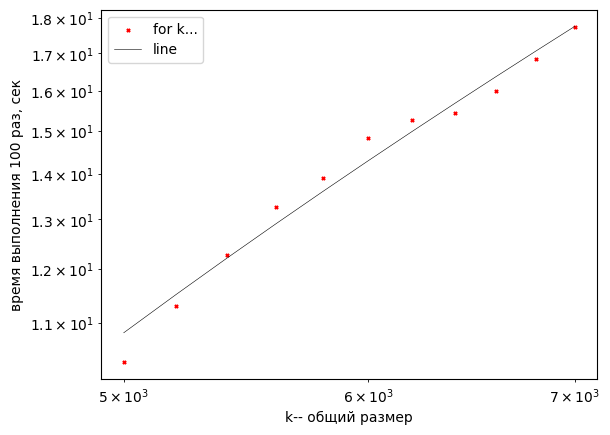

In [13]:
plt.scatter(ks3k, time3k, marker='x', s=5, c='r', label='for k...')
plt.plot(ks3k, line3k(ks3k), color='black', linewidth=0.4, label='line')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('k-- общий размер')
plt.ylabel('время выполнения %s раз, сек'%100)
plt.legend()

In [14]:
print('h=%.0e sec.'%h)
print('a*100*100=%.2e, (b*100*100 + h)=%.2e'%tuple(coef3k))

h=1e+01 sec.
a*100*100=3.47e-03, (b*100*100 + h)=-6.51e+00


Таким орбазом получаем, что $a\sim 3.54e-7 sec., b\sim -6.67e-4, h\sim 2e-6$ Отрицательное $b$ получилось из-за того, что мы смотрим асимтоматику и на малых размерах работают другие правила (влючаюжие кэш), что не вхожит в нашу модель 

Проверим теперь модель на бОльших матрицах

In [15]:
def time_sum_experiment(k, nm, number):
    return timeit.timeit(stmt = "matsum(A[:%(nm)s, :%(k)s], B[:%(k)s, :%(nm)s])" % {'k': k, 'nm': nm},
                         globals = {'matsum': matsum, 'A': A, 'B': B}, number = number)

In [16]:
expgen = range(20000, 20101, 25)

time_exp = list(time_sum_experiment(k, 100, 1)*100 for k in expgen)
ksexp = list(expgen)

time_theor = line3k(ksexp)

In [17]:
print('K   \t\t\t %.0i  \t %.0i  \t %.0i  \t %.0i  \t %.0i'%tuple(ksexp))
print('t_exp1, sec  \t\t %.3f \t %.3f \t %.3f \t %.3f \t %.3f'%tuple(time_exp))
print('t_theor, sec  \t\t %.3f  \t %.3f \t %.3f \t %.3f \t %.3f'%tuple(time_theor))

K   			 20000  	 20025  	 20050  	 20075  	 20100
t_exp1, sec  		 63.615 	 66.599 	 64.770 	 62.774 	 62.961
t_theor, sec  		 62.820  	 62.907 	 62.993 	 63.080 	 63.167


Получили премлемые результаты, которые подтверждают модель

# 4

В простейшем алгоритме произведения матриц используются три цикла: перебирающие элементы $n$ и $m$  матрицы $C$
 и суммирующие по $k$. 
 Сравните время перемножения матриц в зависимости от порядка циклов.
 Оцените объем кэшей разных уровней, проводя эксперименты для матриц разного размера.

Так как нас интересуют циклы по n и m, то возмем функцию с пары

In [18]:
@nb.njit('float64[:,:](float64[:,:],float64[:,:])')
def matsum4(A, B):
    N, K = A.shape # O(1) -m
    M = B.shape[1] # O(1) -m
    C = np.empty((N,M), dtype = nb.float64) # O(NM) -m
    for n in range(N): 
        """
        O(N)
        """
        for m in range(M):
            """
            O(M)
            """
            s = 0  # O(1) -m
            for k in range(K):
                """ 
                O(K)
                """
                s += A[n,k]*B[k,m] 
                """
                O(1) -- умножение n*k и m*k для обращения к памяти 
                O(1) -m -- полученеи A[n,k] и B[k,m] 
                O(1) -- умножение
                O(1) -- сложение
                """
            C[n,m] = s  # O(1) -m
    return C

@nb.njit('float64[:,:](float64[:,:],float64[:,:])')
def matsum4_m(A, B):
    N, K = A.shape # O(1) -m
    M = B.shape[1] # O(1) -m
    C = np.empty((N,M), dtype = nb.float64) # O(NM) -m
    for m in range(M): 
        """
        O(N)
        """
        for n in range(N):
            """
            O(M)
            """
            s = 0  # O(1) -m
            for k in range(K):
                """ 
                O(K)
                """
                s += A[n,k]*B[k,m] 
                """
                O(1) -- умножение n*k и m*k для обращения к памяти 
                O(1) -m -- полученеи A[n,k] и B[k,m] 
                O(1) -- умножение
                O(1) -- сложение
                """
            C[n,m] = s  # O(1) -m
    return C


def time_sum4(k, nm):
    return timeit.timeit(stmt = "matsum4(A[:%(nm)s, :%(k)s], B[:%(k)s, :%(nm)s])" % {'k': k, 'nm': nm},
                         globals = {'matsum4': matsum4, 'A': A, 'B': B}, number = 100)

def time_sum4_m(k, nm):
    return timeit.timeit(stmt = "matsum4_m(A[:%(nm)s, :%(k)s], B[:%(k)s, :%(nm)s])" % {'k': k, 'nm': nm},
                         globals = {'matsum4_m': matsum4_m, 'A': A, 'B': B}, number = 100)

N_max = 10000  # не общий разер матриц
K_max = 10000  # общай размер матриц
A = np.random.random((N_max, K_max))
B = np.random.random((K_max, N_max))

In [19]:
gen4 = range(100, 2001, 200)

time4 = np.array([time_sum4(10, nm) for nm in gen4])
time4_m = np.array([time_sum4_m(10, mn) for mn in gen4])

nms4 = list(gen4)

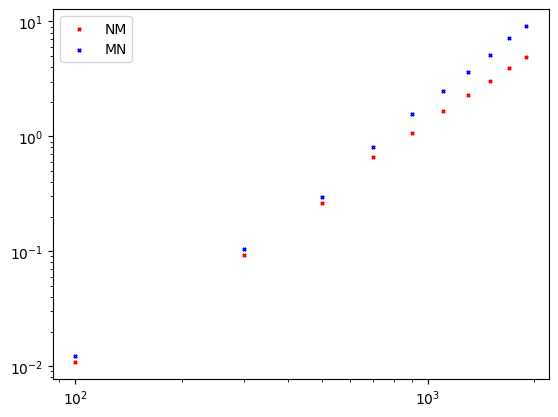

In [20]:
plt.scatter(nms4, time4, marker='x', s=5, c='r', label='NM')
plt.scatter(nms4, time4_m, marker='x', s=5, c='b', label='MN')
plt.yscale('log')
plt.xscale('log')
plt.legend()

Действительно, получается, что порядок имеет значение. В [докуметации](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.html#numpy.ndarray) это написано: "Row-major (C-style) or column-major (Fortran-style) order." Это означает, что выгоднее в M->N случае указывать 

 order='F'

# 5
Обновите функцию для перемножения матриц, используя несколько потоков с помощью numba.prange.
Обновите модель использования вычислительных ресурсов, принимая во внимание число потоков.
Оцените параметры модели из эксперимента.
Какое [параллельное ускорение](https://en.wikipedia.org/wiki/Amdahl%27s_law) вы получили?

In [21]:
N_max = 100  # не общий разер матриц
K_max = 10000  # общай размер матриц
A = np.random.random((N_max, K_max))
B = np.random.random((K_max, N_max))

In [22]:
@nb.njit('float64[:,:](float64[:,:],float64[:,:])', parallel=True)
def pmatsum(A, B):
    N, K = A.shape # const
    M = B.shape[1] # const
    C = np.empty((N,M), dtype = nb.float64) # \sim const
    for n in nb.prange(N): # N
        for m in nb.prange(M): # N
            for k in range(K): # N
                C[n,m] += A[n,k]*B[k,m] # const
    return C

In [23]:
def pmatsum_time(k, thrs):
    return timeit.timeit(stmt = "pmatsum(A[:, :%(k)s], B[:%(k)s, :])" % {'k': k},
                         globals = {'pmatsum': pmatsum, 'A': A, 'B': B, "nb.set_num_threads": nb.set_num_threads},
                           number = 100, setup="""
from numba import set_num_threads
set_num_threads(%s)
"""%thrs)

In [24]:
# посмотрим, какая разница
gen5 = range(100, 1101, 200)

time_st=list([time_sum(k) for k in gen5])
time_2p=list([pmatsum_time(k, 2) for k in gen5])
time_4p=list([pmatsum_time(k, 4) for k in gen5])
time_6p=list([pmatsum_time(k, 6) for k in gen5])

ks5 = list(gen5)

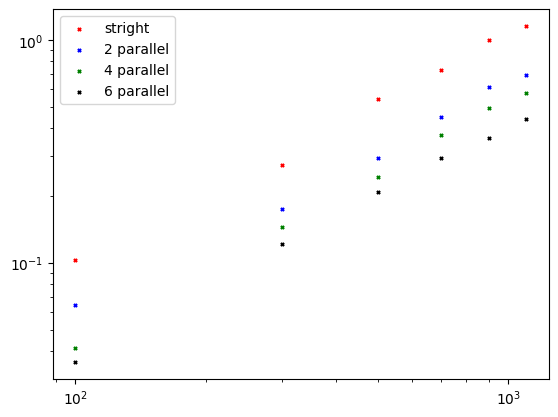

In [25]:
plt.scatter(ks5, time_st, marker='x', s=5, c='r', label='stright')
plt.scatter(ks5, time_2p, marker='x', s=5, c='b', label='2 parallel')
plt.scatter(ks5, time_4p, marker='x', s=5, c='g', label='4 parallel')
plt.scatter(ks5, time_6p, marker='x', s=5, c='black', label='6 parallel')
plt.yscale('log')
plt.xscale('log')
plt.legend()

Получили, что и ожидали: чем больше ядер параллельно запущено, тем больше скорость выполнения, однако сущетвует ограничение в виде шини памяти, которая имеет лимит запросов к памяли за единицу времени.


Теперь попытаемся определить, какое ускорение мы получили:

In [26]:
gen5 = range(5000, 7001, 200)

time_8p=list([pmatsum_time(k, 8) for k in gen5])

coef8p = np.polyfit(list(gen5),time_8p, 1)
line8p = np.poly1d(coef8p)

In [27]:
print('a*100*100=%.2e, \t (b*100*100 + h)=%.2e'%tuple(coef3k))
print('a/8*100*100=%.2e, \t (b*100*100 + h)/8=%.2e'%tuple(coef3k/8))
print('ap*100*100=%.2e, \t (bp*100*100 + h)=%.2e'%tuple(coef8p))

a*100*100=3.47e-03, 	 (b*100*100 + h)=-6.51e+00
a/8*100*100=4.33e-04, 	 (b*100*100 + h)/8=-8.13e-01
ap*100*100=8.31e-04, 	 (bp*100*100 + h)=-1.66e+00


Видно, что $a_{parallel} \sim a/8$, а это нам говорит, что составляюшая $a_{memory}<<a_{arithmetic}$, ведь в параллельной ситуации получаеся  

$$
T(K(NM))= (a_{arithmetic}+a_{memory}/p)\cdot(KNM) + b_{memory}/p\cdot(MN) + h_{memory}
$$

# 6

Сможете ли вы реализовать реализовать на С более быстрый вариант перемножения матриц, чем на numba?



Основываясь на сведениях [[1](https://habr.com/ru/post/484142/)] и [[2](https://habr.com/ru/post/484002/)] можно предположить, что еще бОльшее ускорение уже зависит от качества кода. В [[1](https://habr.com/ru/post/484142/)] видно, что скорость Python с numba на уровне C и дальнейшее ускорение уже будет за счет уменьшения колличества обращений к памяти и т. д., что описано в [[2](https://habr.com/ru/post/484002/)] 

# 7
Реализуйте быстрое произведение матриц, например, используйте [алгоритм Штрассена](https://en.wikipedia.org/wiki/Strassen_algorithm).
Оцените, на матрицах какого размера быстрое произведение матриц быстрее, чем стандартная реализация.
Какой из методов дает меньшую погрешность вычислений?

In [27]:
def split(a):
    if a.shape[0] % 2 != 0 or a.shape[1] % 2 != 0:
        raise Exception("Somth wrong with split")
    cut = a.shape[0] // 2
    a11 = a[:cut, :cut]
    a12 = a[:cut, cut:]
    a21 = a[cut:, :cut]
    a22 = a[cut:, cut:]

    return a11, a12, a21, a22



def shtasen(matrix1, matrix2):
    x, y = matrix1.shape
    if matrix1.shape == (2, 2) and matrix2.shape == (2, 2):
        return matrix1.dot(matrix2)
    
    a11, a12, a21, a22 = split(matrix1)
    b11, b12, b21, b22 = split(matrix2)
    
    d1 = shtasen(a11+a22, b11+b22)
    d2 = shtasen(a21+a22, b11)
    d3 = shtasen(a11, b12-b22)
    d4 = shtasen(a22, b21-b11)
    d5 = shtasen(a11+a12, b22)
    d6 = shtasen(a21-a11, b11+b12)
    d7 = shtasen(a12-a22, b21+b22)

    c11 = d1+d4+d7-d5
    c12 = d3+d5
    c21 = d2+d4
    c22 = d1+d3+d6-d2



    Ct = np.array([np.ravel([c11[i], c12[i]]) for i in range(y//2)])
    Cb = np.array([np.ravel([c21[i], c22[i]]) for i in range(x//2)])

    return np.array([Ct, Cb]).reshape((x, y))

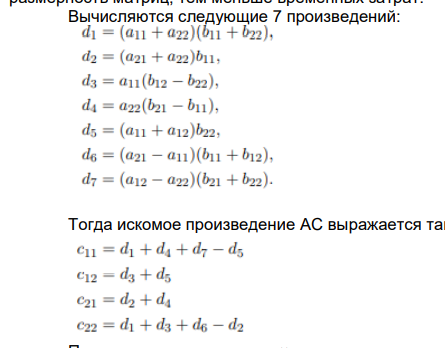

In [29]:

A, B = np.random.random((10000, 10000)), np.random.random((10000, 10000))

def shtasen_time(k, number):
    return timeit.timeit(stmt="shtasen(A[:%(k)s, :%(k)s], B[:%(k)s, :%(k)s])" % {'k': k},
                         globals = {"shtasen": shtasen, 'A': A, 'B': B}, number=number )

def time_mul(n, number):
    return timeit.timeit(stmt = "matsum(A[:, :%(n)s], B[:%(n)s, :])" % {'n': n},
                         globals = {'matsum': matsum, 'A': A, 'B': B}, number = number)

In [30]:
klist = list(2**i for i in range(5, 9))

time_sh = list(shtasen_time(k, 1) for k in klist)
time_nb = list(time_mul(k, 1) for k in klist)

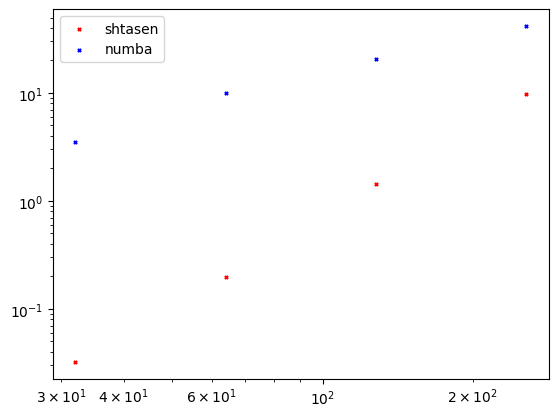

In [31]:
plt.scatter(klist, time_sh, marker='x', s=5, c='r', label='shtasen')
plt.scatter(klist, time_nb, marker='x', s=5, c='b', label='numba')
plt.yscale('log')
plt.xscale('log')
plt.legend()

Так как видно, что на малых матицах матрицах все алгоритм работает лучше, чем numba, то и на больших он будет работать лучше (т.к. асимтотика $O(n^{2.7})$). 